In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import itertools 
import statsmodels.api as sm
import time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

In [3]:
data = pd.read_csv("/Users/joshuawolf/Downloads/CMSE 381/Honors Project/Sean Lahman Database (Baseball)/core/Teams.csv",
                  delimiter = ',')

In [4]:
data = data[["yearID", 'lgID', 'franchID', 'name', 'divID', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin',
            'R', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ERA', 'CG',
            'SHO', 'SV', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP']]

In [5]:
data = data.rename({'yearID': 'Year', 'lgID': 'League', 'franchID': 'FranchiseID', 'divID': 'Division'}, axis=1)

In [6]:
data = data[data['Year'] >= 1995]
data.drop(data[data['Year'] == 2020].index, inplace = True)
data["Playoffs"] = 0
data['Win %'] = data['W']/(data['W'] + data['L'])
data['Win %'] = data['Win %'].round(decimals = 3)

In [7]:
playoff_teams = data[(data['DivWin'] == 'Y') | (data['WCWin'] == 'Y')]
nonplayoff_teams = data[(data['DivWin'] == 'N') & (data['WCWin'] == 'N')]
al_league = data[data['League'] == 'AL']
nl_league = data[data['League'] == 'NL']

In [8]:
data['Playoffs'] = np.where(((data['DivWin'] == 'Y') | (data['WCWin'] == 'Y')), 1, 0)

In [441]:
data
pd.concat([data]).to_csv('CMSE381_Honors_Data.csv', index=False)

In [442]:
data.head()

,Year,League,FranchiseID,name,Division,W,L,DivWin,WCWin,LgWin,...,SV,HA,HRA,BBA,SOA,E,DP,FP,Playoffs,Win %
2181,1995,NL,ATL,Atlanta Braves,E,90,54,Y,N,Y,...,34,1184,107,436,1087,100,113,0.982,1,0.625
2182,1995,AL,BAL,Baltimore Orioles,E,71,73,N,N,N,...,29,1165,149,523,930,72,141,0.986,0,0.493
2183,1995,AL,BOS,Boston Red Sox,E,86,58,Y,N,N,...,39,1338,127,476,888,120,151,0.978,1,0.597
2184,1995,AL,ANA,California Angels,W,78,67,N,N,N,...,42,1310,163,486,901,95,120,0.982,0,0.538
2185,1995,AL,CHW,Chicago White Sox,C,68,76,N,N,N,...,36,1374,164,617,892,108,131,0.980,0,0.472


### Logistic Regression

In [443]:
from sklearn.linear_model import LogisticRegression 

Log Coef: [9.31353452] 
 Log Intercept: [-5.59397109]
Model Score: 0.8064516129032258


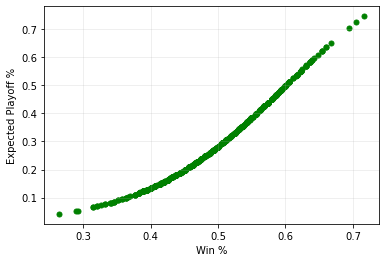

In [444]:
X_log = np.array(data[['Win %']])
y_log = np.array(data.Playoffs)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log,
                                                                    train_size = 0.8, random_state = 5)

clf = LogisticRegression()
model = clf.fit(X_train_log,y_train_log)

print('Log Coef:', model.coef_[0], '\n', 'Log Intercept:', model.intercept_)
y_log = (1/(1+np.exp(-(model.intercept_ + model.coef_[0]*data['Win %']))))

plt.scatter(data['Win %'],y_log, color = 'Green', s = 25)
plt.xlabel('Win %')
plt.ylabel('Expected Playoff %')
plt.grid(alpha = .25)
print('Model Score:', model.score(X_test_log,y_test_log))

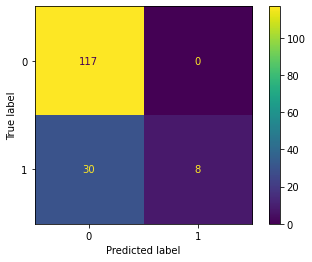

In [445]:
Yhat_log = model.predict(X_test_log)
C = confusion_matrix(y_test_log,Yhat_log)
ConfusionMatrixDisplay(C).plot()

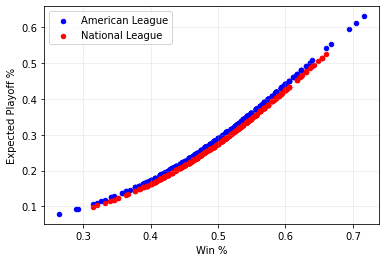

In [446]:
# AL:
al_league = data[data['League'] == "AL"]
X_log_al = np.array(al_league[['Win %']])
y_log_al = np.array(al_league.Playoffs)
model_al = clf.fit(X_log_al,y_log_al)
y_al = (1/(1+np.exp(-(model_al.intercept_ + model_al.coef_[0]*al_league['Win %']))))

#NL:
nl_league = data[data['League'] == 'NL']
X_log_nl = np.array(nl_league[['Win %']])
y_log_nl = np.array(nl_league.Playoffs)
model_nl = clf.fit(X_log_nl,y_log_nl)
y_nl = (1/(1+np.exp(-(model_nl.intercept_ + model_nl.coef_[0]*nl_league['Win %']))))

#Plotting:
plt.scatter(al_league['Win %'],y_al, color = 'Blue', s = 20, label = 'American League')
plt.scatter(nl_league['Win %'],y_nl, color = 'Red', s = 20, label = 'National League')
plt.legend()
plt.xlabel('Win %')
plt.ylabel('Expected Playoff %')
plt.grid(alpha = .25)

### Best Subset

In [447]:
import itertools 
import statsmodels.api as sm
import time

In [448]:
predictors = data[["R", "H", 'HR', 'BB', 'SO', 'SB', 'HBP', 'SF', 'ERA',
                   'SHO','SV', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP']]
response = data['W']

pred_train, pred_test, resp_train, resp_test = train_test_split(predictors,
                                                                response,
                                                                train_size = 0.8,
                                                                random_state = 5)

In [449]:
combos = []
for combo in itertools.combinations(predictors,5):
    combos.append(combo)
print(len(combos))

6188


In [450]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    best_model = sm.OLS(resp_train,pred_train[list(feature_set)])
    regr = best_model.fit()
    RSS = ((regr.predict(pred_test[list(feature_set)]) - resp_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [451]:
def getBest(k):
    
    tic = time.time()
    
    results = []

    for combo in itertools.combinations(list(pred_train),k):
        results.append(processSubset(combo))
    
    
    models = pd.DataFrame(results)
    

    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    return best_model

In [452]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 17 models on 1 predictors in 0.04538130760192871 seconds.
Processed 136 models on 2 predictors in 0.21508193016052246 seconds.
Processed 680 models on 3 predictors in 1.6421558856964111 seconds.
Processed 2380 models on 4 predictors in 3.899827241897583 seconds.
Processed 6188 models on 5 predictors in 10.61194396018982 seconds.
Processed 12376 models on 6 predictors in 26.21989417076111 seconds.
Processed 19448 models on 7 predictors in 41.9661660194397 seconds.
Total elapsed time: 85.36034989356995 seconds.


In [453]:
print(models_best.apply(lambda row: row[1].rsquared, axis=1))
models_best

1    0.984183
2    0.992930
3    0.996140
4    0.997284
5    0.997672
6    0.998005
7    0.998034
dtype: float64


,RSS,model
1,15559.657530,<statsmodels.regression.linear_model.Regressio...
2,7691.913065,<statsmodels.regression.linear_model.Regressio...
3,4082.699429,<statsmodels.regression.linear_model.Regressio...
4,2858.602666,<statsmodels.regression.linear_model.Regressio...
5,2403.890293,<statsmodels.regression.linear_model.Regressio...
6,2137.937596,<statsmodels.regression.linear_model.Regressio...
7,2082.502758,<statsmodels.regression.linear_model.Regressio...


Text(0, 0.5, 'BIC')

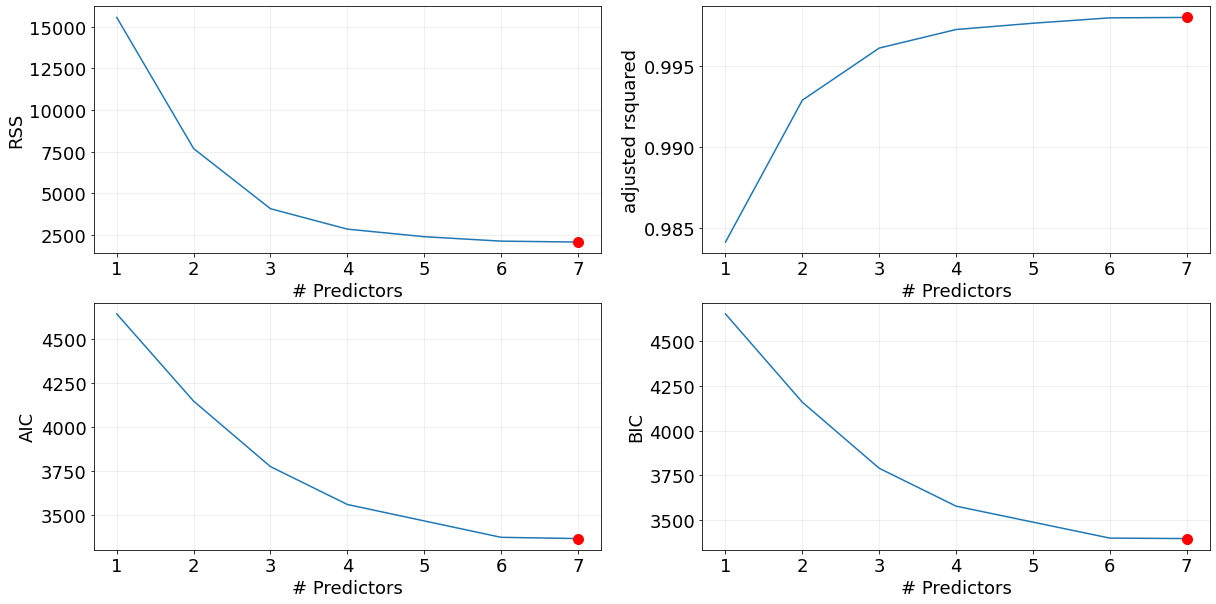

In [454]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)


plt.plot(models_best["RSS"])
plt.plot(models_best['RSS'].argmin()+1, models_best['RSS'].min(), "or")
plt.grid(alpha = .25)
plt.xlabel('# Predictors')
plt.ylabel('RSS')

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)
models_best.apply(lambda row: row[1], axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.grid(alpha = .25)
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.grid(alpha = .25)
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.grid(alpha = .25)
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [455]:
models_best.iloc[3,1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      W   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          5.645e+04
Date:                Thu, 28 Apr 2022   Prob (F-statistic):                        0.00
Time:                        23:44:32   Log-Likelihood:                         -1776.4
No. Observations:                 619   AIC:                                      3561.
Df Residuals:                     615   BIC:                                      3579.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
R              0.0942      0.002     46.110      0.000       0.090       0.098
ERA           -7.7963      0.267    -29.200      0.000      -8.321      -7.272
SV             0.6674      0.025     27.220      0.000       0.619       0.716
SOA            0.0145      0.001     16.092      0.000       0.013       0.016
==============================================================================
Omnibus:                        4.336   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                5.224
Skew:                           0.045   Prob(JB):                       0.0734
Kurtosis:                       3.441   Cond. No.                     2.14e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Forward Selection 

In [456]:
def forward(predictor):

    remaining_predictors = [p for p in pred_train.columns if p not in predictor]
    
    tic = time.time()
    
    results = []
    
    for pred in remaining_predictors:
        results.append(processSubset(predictor + [pred]))

    
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictor)+1, "predictors in", (toc-tic), "seconds.")
    
    return best_model


In [457]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()

predictors_list = []

for i in range(1,len(pred_train.columns)+1): 
       
    models_fwd.loc[i] = forward(predictors_list)

    predictors_list = models_fwd.loc[i]["model"].model.exog_names
    
    print('Starting with predictors:\n', predictors_list)


toc = time.time()
print("Total elapsed time:", round((toc-tic),2), "seconds.")

Processed  17 models on 1 predictors in 0.03798484802246094 seconds.
Starting with predictors:
 ['R']
Processed  16 models on 2 predictors in 0.027846813201904297 seconds.
Starting with predictors:
 ['R', 'SV']
Processed  15 models on 3 predictors in 0.026185035705566406 seconds.
Starting with predictors:
 ['R', 'SV', 'ERA']
Processed  14 models on 4 predictors in 0.027515172958374023 seconds.
Starting with predictors:
 ['R', 'SV', 'ERA', 'SOA']
Processed  13 models on 5 predictors in 0.026021242141723633 seconds.
Starting with predictors:
 ['R', 'SV', 'ERA', 'SOA', 'HA']
Processed  12 models on 6 predictors in 0.024675846099853516 seconds.
Starting with predictors:
 ['R', 'SV', 'ERA', 'SOA', 'HA', 'SHO']
Processed  11 models on 7 predictors in 0.02446579933166504 seconds.
Starting with predictors:
 ['R', 'SV', 'ERA', 'SOA', 'HA', 'SHO', 'DP']
Processed  10 models on 8 predictors in 0.02149033546447754 seconds.
Starting with predictors:
 ['R', 'SV', 'ERA', 'SOA', 'HA', 'SHO', 'DP', 'HR

In [458]:
print('Adjusted R^2:', '\n', models_fwd.apply(lambda row: row[1].rsquared_adj, axis=1))
models_fwd

Adjusted R^2: 
 1     0.984157
2     0.992907
3     0.996121
4     0.997266
5     0.997653
6     0.997985
7     0.998012
8     0.998016
9     0.998044
10    0.998059
11    0.998061
12    0.998075
13    0.998095
14    0.998093
15    0.998095
16    0.998166
17    0.998185
dtype: float64


,RSS,model
1,15559.657530,<statsmodels.regression.linear_model.Regressio...
2,7691.913065,<statsmodels.regression.linear_model.Regressio...
3,4082.699429,<statsmodels.regression.linear_model.Regressio...
4,2858.602666,<statsmodels.regression.linear_model.Regressio...
5,2403.890293,<statsmodels.regression.linear_model.Regressio...
6,2137.937596,<statsmodels.regression.linear_model.Regressio...
7,2082.502758,<statsmodels.regression.linear_model.Regressio...
8,2051.549434,<statsmodels.regression.linear_model.Regressio...
9,2028.002086,<statsmodels.regression.linear_model.Regressio...
10,2014.412626,<statsmodels.regression.linear_model.Regressio...


Text(0, 0.5, 'BIC')

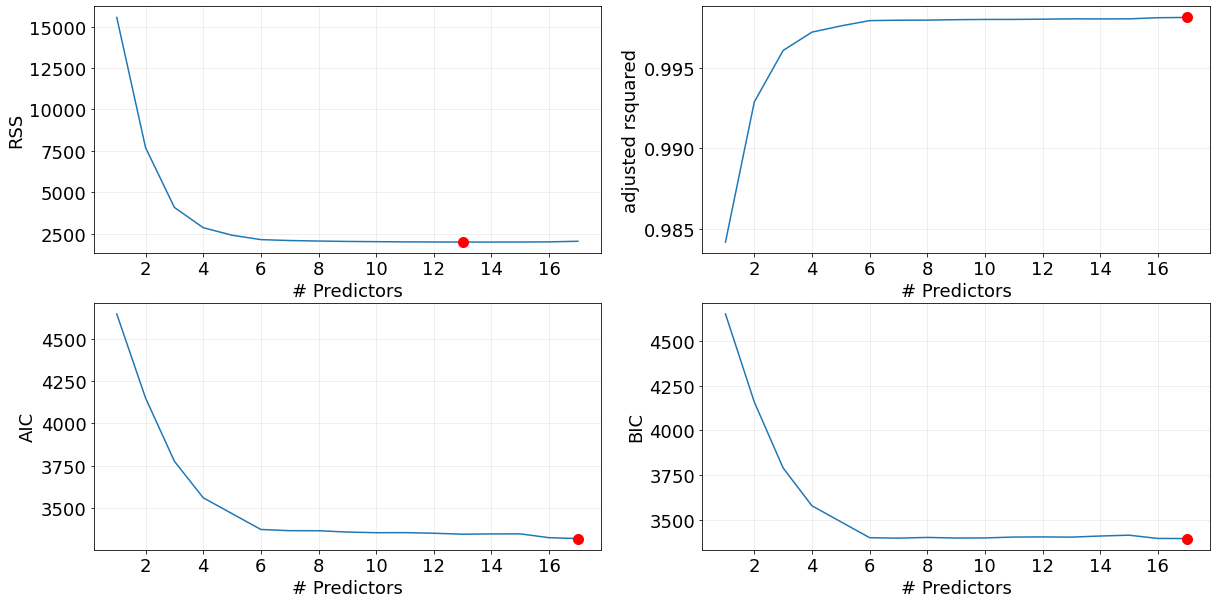

In [459]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)

plt.plot(models_fwd["RSS"])
plt.plot(models_fwd['RSS'].argmin()+1, models_fwd['RSS'].min(), "or")
plt.grid(alpha = .25)
plt.xlabel('# Predictors')
plt.ylabel('RSS')


rsquared_adj = models_fwd.apply(lambda row: row[1].rsquared_adj, axis=1)
models_fwd.apply(lambda row: row[1], axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.grid(alpha = .25)
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

aic = models_fwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.grid(alpha = .25)
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_fwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.grid(alpha = .25)
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [460]:
models_fwd.iloc[3,1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      W   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          5.645e+04
Date:                Thu, 28 Apr 2022   Prob (F-statistic):                        0.00
Time:                        23:44:33   Log-Likelihood:                         -1776.4
No. Observations:                 619   AIC:                                      3561.
Df Residuals:                     615   BIC:                                      3579.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
R              0.0942      0.002     46.110      0.000       0.090       0.098
SV             0.6674      0.025     27.220      0.000       0.619       0.716
ERA           -7.7963      0.267    -29.200      0.000      -8.321      -7.272
SOA            0.0145      0.001     16.092      0.000       0.013       0.016
==============================================================================
Omnibus:                        4.336   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                5.224
Skew:                           0.045   Prob(JB):                       0.0734
Kurtosis:                       3.441   Cond. No.                     2.14e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### LDA vs. QDA

In [461]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

In [462]:
best_pred = data[['SHO', 'ERA', "R"]]
y = data['Playoffs']
X_train, X_test, y_train, y_test = train_test_split(best_pred, y, train_size = 0.8, random_state = 5)

lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train, y_train)
lda_yhat = lda_model.predict(X_test)
lda_score = lda_model.score(X_test, y_test)


qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train, y_train)
qda_yhat = qda_model.predict(X_test)
qda_score = lda_model.score(X_test, y_test)

print("LDA score:", lda_score, '\n', 'QDA Score:', qda_score)

LDA score: 0.864516129032258 
 QDA Score: 0.864516129032258


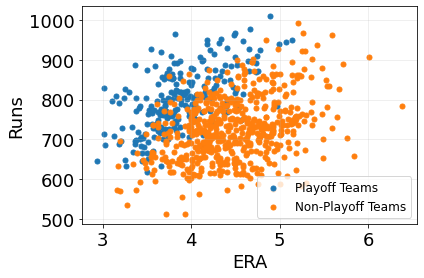

In [463]:
plt.scatter(playoff_teams['ERA'], playoff_teams['R'],
            label = 'Playoff Teams', s = 25)

plt.scatter(nonplayoff_teams['ERA'], nonplayoff_teams['R'],
            label = 'Non-Playoff Teams', s = 25)
plt.grid(alpha = .25)
plt.xlabel('ERA')
plt.ylabel('Runs')
plt.legend(fontsize = 12)

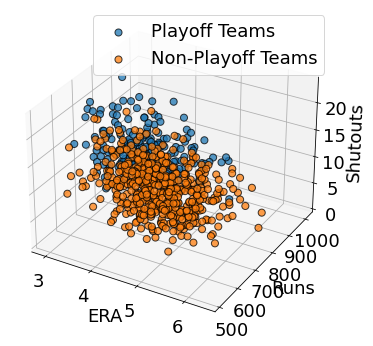

In [464]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(playoff_teams['ERA'], playoff_teams['R'], playoff_teams['SHO'],
           linewidths=1, alpha=.75,
           edgecolor='k',
           s = 50,
          label = 'Playoff Teams')

ax.scatter(nonplayoff_teams['ERA'], nonplayoff_teams['R'], nonplayoff_teams['SHO'],
           linewidths=1, alpha=.75,
           edgecolor='k',
           s = 50,
          label = 'Non-Playoff Teams')
ax.set_xlabel('ERA')
ax.set_ylabel("Runs")
ax.set_zlabel('Shutouts')
plt.legend()
plt.show()

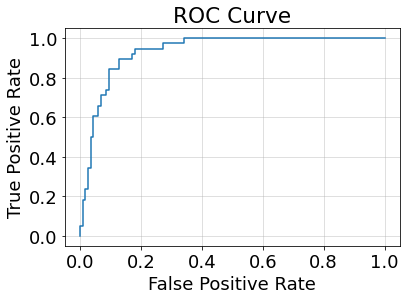

AUC: 0.934322986954566


In [465]:
y_pred_proba = lda_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.grid(alpha = .5)
plt.show()

auc_lda = metrics.roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc_lda)

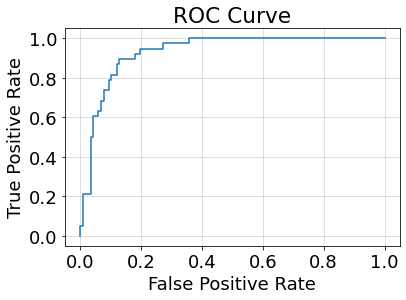

AUC: 0.9311740890688258


In [466]:
y_pred_proba_q = qda_model.predict_proba(X_test)[::,1]
fpr_q, tpr_q, _ = metrics.roc_curve(y_test,  y_pred_proba_q)

#create ROC curve
plt.plot(fpr_q,tpr_q)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.grid(alpha = .5)
plt.show()

auc_qda = metrics.roc_auc_score(y_test, y_pred_proba_q)
print('AUC:', auc_qda)